In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from matplotlib import pyplot as plt
import sqlite3
import datetime
import numpy as np
import os
from keras import backend as K
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

Using TensorFlow backend.


In [2]:
#abro la conexión
con = sqlite3.connect("database/ALUAR.db")

In [3]:
df2 = pd.read_sql_query("select FT_TURNO, TU_SEMI_TURNO, CUBA, HBD, WRMI, TFOIN, TFAIN, NDAL2O3, NTEA,NIANO from 'HITM_PS'", con)

In [4]:
df2["FT_TURNO"] = df2["FT_TURNO"].apply(lambda x:datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

In [5]:
df2_index = df2.set_index(["FT_TURNO", "TU_SEMI_TURNO", "CUBA"])

In [6]:
df2_index.head()

HBD  WRMI  TFOIN    TFAIN  NDAL2O3  NTEA  \
FT_TURNO   TU_SEMI_TURNO CUBA                                              
2019-06-01 1             501   18.0  52.0    0.0   0.0000    556.0   0.0   
                         502   18.0  55.0    0.0   0.0000    526.0   0.0   
                         503   18.0  53.0    0.0   0.0000    484.0   0.0   
                         504   18.0  72.0    0.0  11.0116    548.0   0.0   
                         505   15.0  68.0    0.0   0.0000    516.0   0.0   

                               NIANO  
FT_TURNO   TU_SEMI_TURNO CUBA         
2019-06-01 1             501       0  
                         502       0  
                         503       0  
                         504       0  
                         505       0

/home/cselmo/miniconda3/envs/CV/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


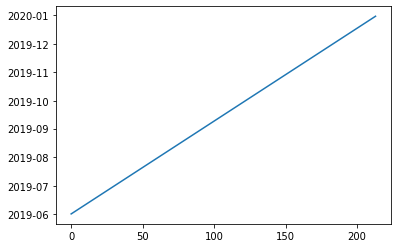

In [7]:
plt.plot(df2_index.index.unique(level="FT_TURNO").values)
plt.show()

In [8]:
cubas = df2_index.index.levels[2]

In [9]:
len(cubas)

480

# Saco las cubas con NaNs

In [10]:
idx = pd.IndexSlice
to_drop = []
for cuba in cubas:
    cant_datos = len(df2_index.loc[idx[:,:, cuba], ["WRMI"]])
    cant_nans = (df2_index.loc[idx[:,:, cuba], ["WRMI"]].isna()==True).sum()["WRMI"]
    if cant_nans:
        to_drop.append(cuba)

In [11]:
df2_index.drop(index=to_drop, level=2,inplace=True)


In [12]:
len(df2_index.index.unique(level="CUBA"))

347

In [13]:
df2_index.values.shape

(445548, 7)

In [14]:
for cuba in df2_index.index.unique(level="CUBA"):
    df2_index.loc[idx[:,:,cuba],:] = df2_index.loc[idx[:,:,cuba],:].fillna(method = "bfill")

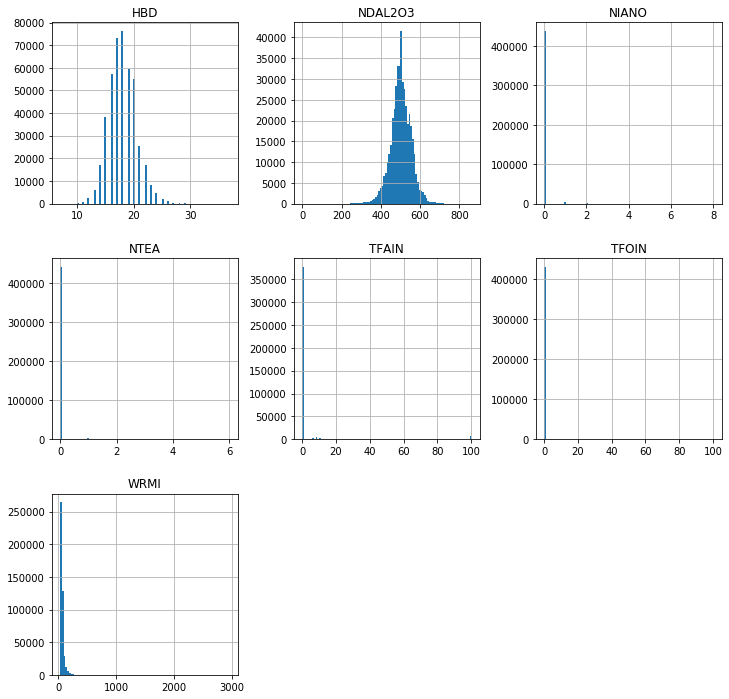

In [15]:
df2_index.hist(bins=100,figsize=[12,12])
plt.show()

In [16]:
df2_index["TFAIN_label"] = df2_index["TFAIN"]>1

In [17]:
df2_index.corr()

,HBD,WRMI,TFOIN,TFAIN,NDAL2O3,NTEA,NIANO,TFAIN_label
HBD,1.000000,0.044048,0.005260,0.056617,0.026560,0.017025,0.005850,0.067547
WRMI,0.044048,1.000000,0.458403,0.626142,-0.002736,0.109410,0.110382,0.555057
TFOIN,0.005260,0.458403,1.000000,0.537261,-0.000099,0.070788,0.082587,0.351617
TFAIN,0.056617,0.626142,0.537261,1.000000,0.033915,0.039680,0.084012,0.775887
NDAL2O3,0.026560,-0.002736,-0.000099,0.033915,1.000000,0.145942,-0.083163,0.048412
NTEA,0.017025,0.109410,0.070788,0.039680,0.145942,1.000000,0.008271,0.054945
NIANO,0.005850,0.110382,0.082587,0.084012,-0.083163,0.008271,1.000000,0.118656
TFAIN_label,0.067547,0.555057,0.351617,0.775887,0.048412,0.054945,0.118656,1.000000


# Entreno con algunas cubas, testeo con otras

Clasifico TFAIN_label en función de HBD, WRMI, TFOIN, NDAL2O3 y NTEA

In [18]:
cubas = df2_index.index.unique(level="CUBA")
print(len(cubas))

347


In [19]:
p_train = 0.8
rand_numbers = np.random.rand(347)
mask_train =rand_numbers < p_train
mask_test =rand_numbers >= p_train

In [20]:
df = df2_index.loc[idx[:,:,501],["HBD", "WRMI","TFOIN","NDAL2O3","NTEA", "TFAIN_label"]]

In [21]:
df.head()

HBD  WRMI  TFOIN  NDAL2O3  NTEA  TFAIN_label
FT_TURNO   TU_SEMI_TURNO CUBA                                               
2019-06-01 1             501   18.0  52.0    0.0    556.0   0.0        False
           2             501   18.0  54.0    0.0    585.0   0.0        False
           3             501   18.0  56.0    0.0    595.0   0.0        False
           4             501   18.0  55.0    0.0    571.0   0.0        False
           5             501   18.0  53.0    0.0    523.0   0.0        False

In [22]:
cubas_train = cubas[mask_train]
cubas_test = cubas[mask_test]

In [23]:
len(cubas_train)

284

In [24]:
len(cubas_test)

63

In [25]:
idx = pd.IndexSlice
T = 50
X_train  = list()
y_train = list()
for cuba in cubas_train:
    array= df2_index.loc[idx[:,:,cuba],["HBD", "WRMI","TFOIN","NDAL2O3","NTEA", "TFAIN_label"]].values
    for t_idx in range(array.shape[0]-T+1):
        X_train.append(array[t_idx:t_idx+T,:-1])
        y_train.append(array[t_idx+T-1,-1])
X_train = np.array(X_train)
y_train = np.array(y_train)

In [26]:
X_train.shape

(350740, 50, 5)

In [27]:
sum(y_train)/len(y_train)

0.14747961452928096

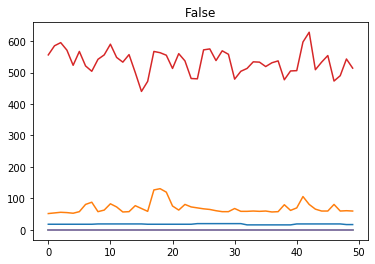

In [28]:
n = 0
plt.plot(X_train[n])
plt.title(f'{y_train[n]}')
plt.show()

In [29]:
idx = pd.IndexSlice
T = 50
X_test  = list()
y_test = list()
for cuba in cubas_test:
    array=df = df2_index.loc[idx[:,:,cuba],["HBD", "WRMI","TFOIN","NDAL2O3","NTEA", "TFAIN_label"]].values
    for t_idx in range(array.shape[0]-T+1):
        X_test.append(array[t_idx:t_idx+T,:-1])
        y_test.append(array[t_idx+T-1,-1])
X_test = np.array(X_test)
y_test = np.array(y_test)

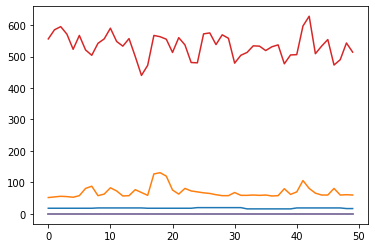

In [30]:
plt.plot(X_train[0])
plt.show()

In [31]:
sum(y_test)/len(y_test)

0.1697705802968961

In [37]:
from keras.layers import Conv1D, Flatten, Dense, MaxPool1D, BatchNormalization, Dropout, Activation
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
es = EarlyStopping(monitor="val_accuracy", patience= 5, verbose=1)
mcp = ModelCheckpoint("best_weights.hdf5", monitor="val_accuracy",verbose=1, save_best_only=True)
rlr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=2, verbose=1)

In [38]:
model = Sequential()
model.add(BatchNormalization(input_shape=(50,5)))
model.add(Conv1D(filters = 100, kernel_size= 3, strides=1, padding="valid"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv1D(filters = 100, kernel_size= 3, strides=1, padding="valid", dilation_rate=2))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv1D(filters = 100, kernel_size= 3, strides=1, padding="valid", dilation_rate=4))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Flatten())
model.add(Dense(100, activation="relu"))
model.add(Dense(20, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [39]:
model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")

In [40]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_5 (Batch (None, 50, 5)             20        
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 48, 100)           1600      
_________________________________________________________________
batch_normalization_6 (Batch (None, 48, 100)           400       
_________________________________________________________________
activation_4 (Activation)    (None, 48, 100)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 44, 100)           30100     
_________________________________________________________________
batch_normalization_7 (Batch (None, 44, 100)           400       
_________________________________________________________________
activation_5 (Activation)    (None, 44, 100)          

In [41]:
model.fit(x=X_train, y=y_train,callbacks=[es, rlr,mcp], validation_data=(X_test, y_test),epochs=100)

Train on 350740 samples, validate on 77805 samples
Epoch 1/100
350740/350740 [==============================] - 70s 201us/step - loss: 0.1642 - accuracy: 0.9358 - val_loss: 0.1683 - val_accuracy: 0.9317

Epoch 00001: val_accuracy improved from -inf to 0.93170, saving model to best_weights.hdf5
Epoch 2/100
350740/350740 [==============================] - 72s 205us/step - loss: 0.1493 - accuracy: 0.9407 - val_loss: 0.1590 - val_accuracy: 0.9359

Epoch 00002: val_accuracy improved from 0.93170 to 0.93585, saving model to best_weights.hdf5
Epoch 3/100
350740/350740 [==============================] - 74s 212us/step - loss: 0.1453 - accuracy: 0.9422 - val_loss: 0.1552 - val_accuracy: 0.9382

Epoch 00003: val_accuracy improved from 0.93585 to 0.93817, saving model to best_weights.hdf5
Epoch 4/100
350740/350740 [==============================] - 73s 207us/step - loss: 0.1421 - accuracy: 0.9436 - val_loss: 0.1816 - val_accuracy: 0.9245

Epoch 00004: val_accuracy did not improve from 0.93817
Epo

In [42]:
model.load_weights("best_weights.hdf5")

In [43]:
model.evaluate(X_test,y_test)

77805/77805 [==============================] - 4s 53us/step


[0.15104781078894644, 0.9398110508918762]

In [44]:
y_pred = model.predict(X_test)

In [45]:
y_pred

array([[5.3308308e-03],
       [4.5654476e-03],
       [4.6372414e-05],
       ...,
       [1.1415780e-03],
       [7.1260333e-04],
       [1.2378767e-03]], dtype=float32)

In [46]:
y_test

array([False, False, False, ..., False, False, False])

In [47]:
from sklearn.metrics import confusion_matrix

In [48]:
confusion_matrix(y_test*1, y_pred>0.5)

array([[63200,  1396],
       [ 3287,  9922]])

In [49]:
from sklearn.metrics import f1_score

In [50]:
f1_score(y_test*1, y_pred>0.5)

0.809067558201166